In [1]:
import os
import numpy as np
import time
import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

from utils import train, losses, metrics
from sklearn.model_selection import train_test_split
from model import PSPNet
from dataset.dataset import MyDataset

import albumentations as albu
import matplotlib.pyplot as plt

In [2]:
images_dir = './data/CamVid/images'
masks_dir = './data/CamVid/masks'

In [7]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def normalize_input(x, **kwargs):
    return x / 255.0

    
def preprocess_input(
    x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(), c='red')
        plt.imshow(image)
    plt.show()
    
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

# helper function for labeling multiclass masks
def labelVisualize(num_class, color_dict, img):
    img_out = img[0,:,:] if len(img.shape) == 3 else img
    img_out = np.zeros(img_out.shape + (3,))
    for i in range(num_class):
        img_out[img[i,:,:]==1, :] = COLOR_DICT[i]
    return img_out / 255

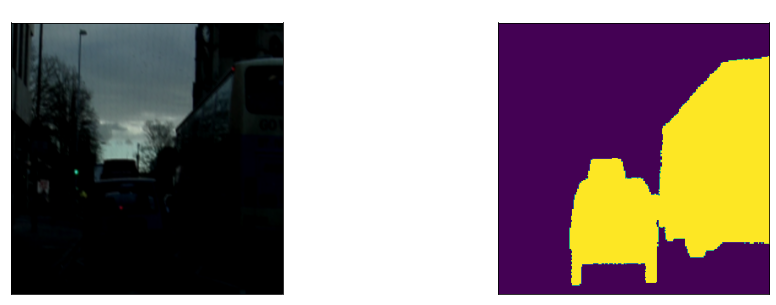

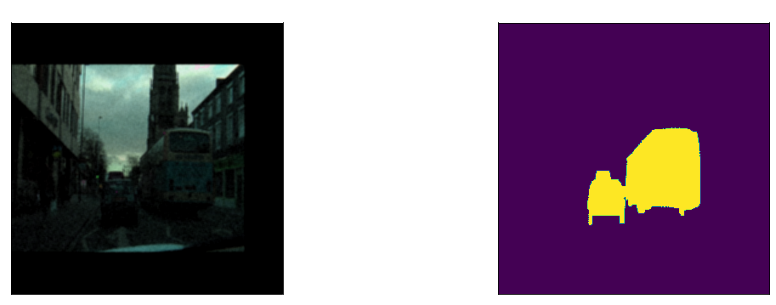

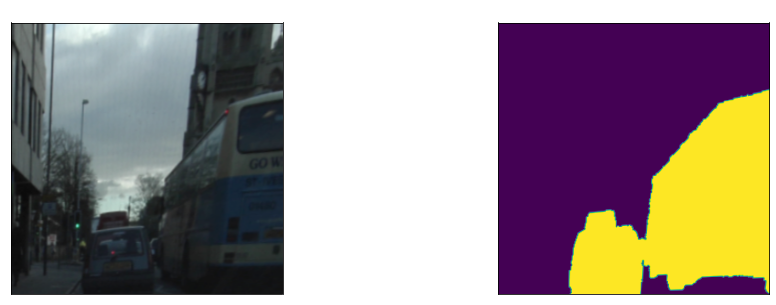

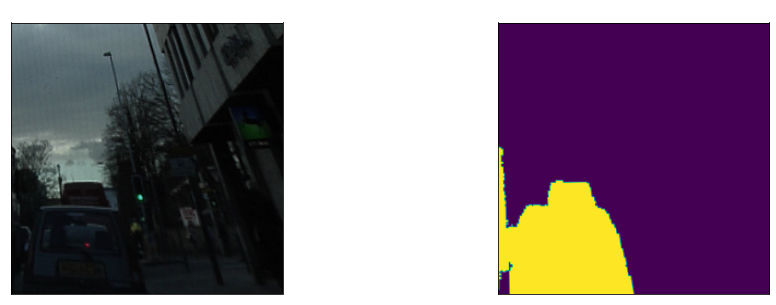

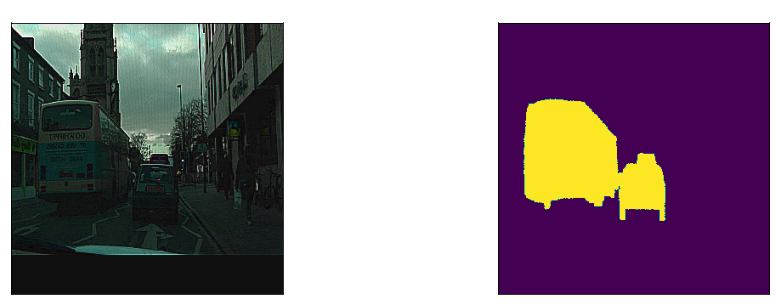

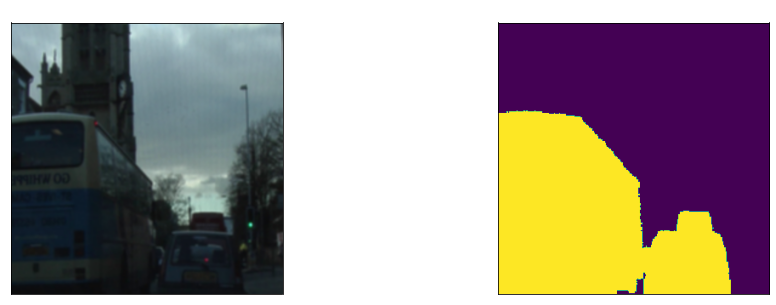

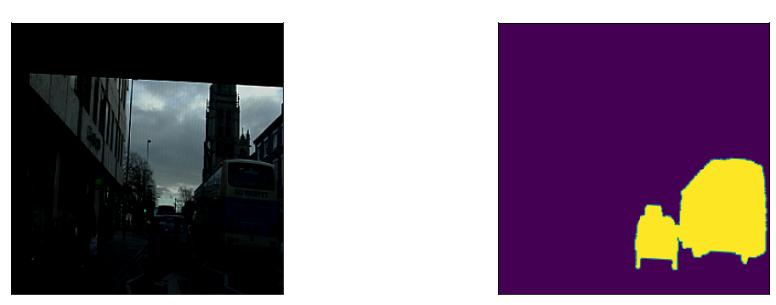

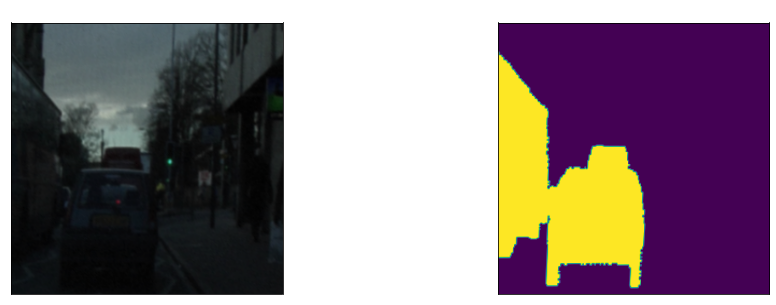

In [8]:
#### Visualize resulted augmented images and masks
x_train_dir = './data/CamVid/images/train'
y_train_dir = './data/CamVid/masks/train'

pipeline_aug = get_training_augmentation()
pipeline_prepro = get_preprocessing(normalize_input)

raw_dataset = MyDataset(
    x_train_dir,
    y_train_dir,
    preprocessing=None,
    classes=['car'],
)

augmented_dataset = MyDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=pipeline_aug,
    preprocessing=None,
    classes=['car'],
)



# same image with different random transforms
for i in range(8):
    image, mask = augmented_dataset[4]
    visualize(image=image, mask=mask.squeeze(-1))

In [8]:
device = 'cuda'
train_dir = os.path.join(images_dir, 'train')
valid_dir = os.path.join(images_dir, 'valid')
tr_masks_dir = os.path.join(masks_dir, 'train')
va_masks_dir = os.path.join(masks_dir, 'valid')

# class labels for cityscape dataset
# CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
#            'tree', 'signsymbol', 'fence', 'car',
#            'pedestrian', 'bicyclist', 'unlabelled']
CLASSES = ['car']


# Load model
model = PSPNet(
    encoder_name="mobilenetv1",
    encoder_weights=False,
    encoder_depth=5,
    psp_out_channels=512,              # PSP out channels after concat not yet final
    psp_use_batchnorm=True,
    psp_dropout=0.2,
    in_channels=3,
    classes=1,
    activation=None,     # Optional[Union[str, callable]]
    upsampling=8,
    dilated=False,
    aux_params={'classes': 1, 'height': 320,
                'width': 320, 'dropout': 0.2},  # Opt
)

# Define parameters
loss = losses.PSPLoss()
l_metrics = [metrics.IoU(threshold=0.5),
             metrics.Accuracy(),
             metrics.Recall()]
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

# Create Data Loaders
pipeline_aug = get_training_augmentation()
pipeline_prepro = get_preprocessing(normalize_input)

train_dataset = MyDataset(train_dir, tr_masks_dir, augmentation=pipeline_aug, preprocessing=pipeline_prepro, classes=CLASSES)
valid_dataset = MyDataset(valid_dir, va_masks_dir, augmentation=pipeline_aug, preprocessing=pipeline_prepro, classes=CLASSES)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)


# Load model and data
train_epoch = train.TrainEpoch(
    model=model,
    loss=loss,
    metrics=l_metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)
valid_epoch = train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=l_metrics,
    device=device,
    verbose=True,
)

In [9]:
x, y = iter(train_loader).__next__()

In [10]:
x.shape

torch.Size([8, 3, 320, 320])

In [46]:
features = model.encoder(x.to(device))
labels = model.classification_head(features)
labels.shape

torch.Size([8, 1, 320, 320])

## Training

In [10]:
# Run training

epochs = 1

for i in range(epochs):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

#     # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 101/101 [00:03<00:00, 25.35it/s, psp_loss - 0.1407, iou_score - 1.238e-10, accuracy - 0.9811, recall - 1.238e-10]


## Prediction

In [5]:
# load best saved checkpoint
best_model = torch.load('./models/210210_diceloss_e100.pth')

In [6]:
# create test dataset
x_test_dir = './data/CamVid/images/test'
y_test_dir = './data/CamVid/masks/test'

pipeline_aug = get_training_augmentation()
pipeline_prepro = get_preprocessing(normalize_input)

# class labels for cityscape dataset
CLASSES = ['car']
ALL_CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']


test_dataset = MyDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(),
    preprocessing=pipeline_prepro,
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [7]:
# evaluate model on test set
device = 'cuda'
loss = losses.DiceLoss()
l_metrics = [metrics.IoU(threshold=0.5),
             metrics.Accuracy(),
             metrics.Recall()]

test_epoch = train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=l_metrics,
    device=device,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:06<00:00, 37.75it/s, dice_loss - 0.2892, iou_score - 0.6182, accuracy - 0.9898, recall - 0.7637]


## Visualization

(3, 384, 480)
(1, 384, 480)
torch.Size([1, 1, 384, 480])


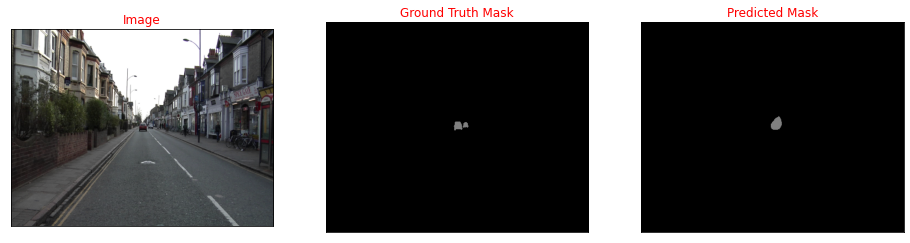

(3, 384, 480)
(1, 384, 480)
torch.Size([1, 1, 384, 480])


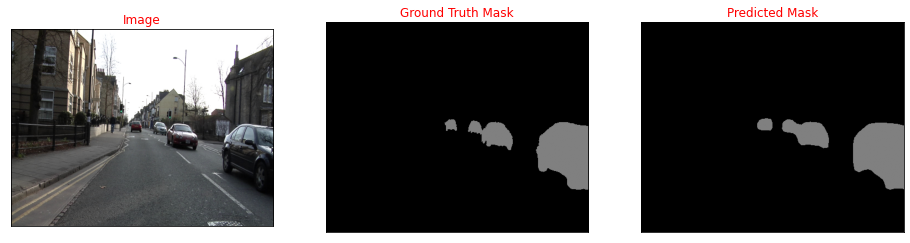

(3, 384, 480)
(1, 384, 480)
torch.Size([1, 1, 384, 480])


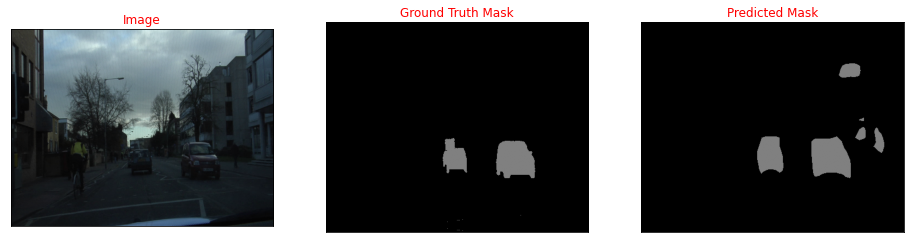

(3, 384, 480)
(1, 384, 480)
torch.Size([1, 1, 384, 480])


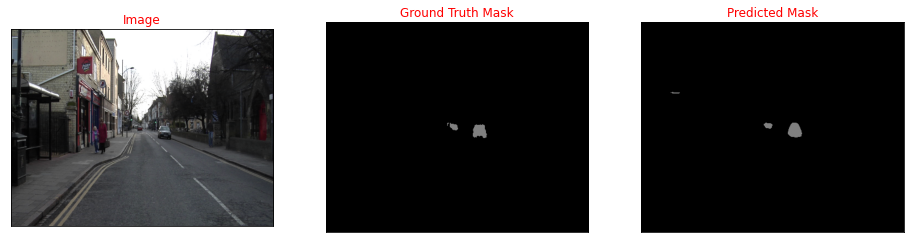

(3, 384, 480)
(1, 384, 480)
torch.Size([1, 1, 384, 480])


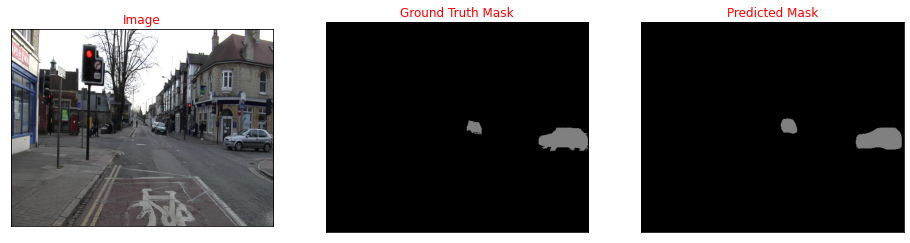

In [14]:
device = 'cuda'

# test dataset without transformations for image visualization
test_dataset_vis = MyDataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    print(image.shape)
    print(gt_mask.shape)
    gt_mask = labelVisualize(len(CLASSES), COLOR_DICT, gt_mask)
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    print(pr_mask.shape)
    pr_mask = labelVisualize(len(CLASSES), COLOR_DICT, pr_mask[0].cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask.squeeze(), 
        predicted_mask=pr_mask
    )

## Export to ONNX

In [5]:
import torch.onnx

In [11]:
model = torch.load('./models/210210_diceloss_e100.pth')
dummy_input = torch.randn(8, 3, 320, 320, device='cuda')

torch.onnx.export(model, dummy_input, './models/210210_diceloss_e100.onnx', export_params=True, verbose=True)

/home/ubuntu/miniconda3/envs/torch_py38/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:266: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  warnings.warn("You are trying to export the model with " + onnx_op + " for ONNX opset version "
/home/ubuntu/miniconda3/envs/torch_py38/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:182: UserWarning: ONNX export failed on upsample_bilinear2d because align_corners == True not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


RuntimeError: Unsupported: ONNX export of operator adaptive_avg_pool2d, since output size is not factor of input size. Please open a bug to request ONNX export support for the missing operator.